# EV Sales India Analysis

In [8]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from rich import print
import tensorflow as tf
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

Load the dataset

In [9]:
import pandas as pd

# Load the dataset
df = pd.read_csv('EV_INDIA_CARS.csv')

# Display first few rows
print(df.head())


Car_name            Car_price Batter_cap          Drive_range   
0    MG Comet EV           7.98  lakh   17.3 kWh  230  km/full charge  \
1  Tata Tiago EV   8.69 - 11.99  lakh   19.2 KWh   250 km/full charge   
2  Tata Tigor EV  12.49 - 13.75  lakh     26 kWh   315 km/full charge   
3       MG ZS EV  23.38 - 27.40  lakh   50.3 kWh   461 km/full charge   
4     BYD Atto 3  33.99 - 34.49  lakh  60.48 kWh   521 km/full charge   

               Power     Charge_time     transmission Boot_space Top_speed  
0          41.42 Bhp         7 Hours        Automatic        NaN       NaN  
1  60.34 - 73.75 Bhp  58 Min(10-80%)   240 L (Liters)  Automatic       NaN  
2          73.75 Bhp            7.5h   316 L (Liters)  Automatic       NaN  
3         174.33 Bhp  8.5 to 9 Hours        Automatic        NaN       NaN  
4         201.15 Bhp    9.5-10 Hours  440L L (Liters)  Automatic       NaN

In [10]:
# Basic information
df.info()

# Summary statistics for numerical columns
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Car_name      30 non-null     object
 1   Car_price     30 non-null     object
 2   Batter_cap    27 non-null     object
 3   Drive_range   30 non-null     object
 4   Power         30 non-null     object
 5   Charge_time   30 non-null     object
 6   transmission  28 non-null     object
 7   Boot_space    12 non-null     object
 8   Top_speed     6 non-null      object
dtypes: object(9)
memory usage: 2.2+ KB


,Car_name,Car_price,Batter_cap,Drive_range,Power,Charge_time,transmission,Boot_space,Top_speed
count,30,30,27,30,30,30,28,12,6
unique,30,29,16,18,18,14,12,2,4
top,MG Comet EV,1.9 cr,17.3 kWh,230 km/full charge,41.42 Bhp,Automatic,Automatic,Automatic,200kmph
freq,1,2,2,2,2,7,12,10,3


In [11]:
# Checking for missing values
df.isnull().sum()


Car_name         0
Car_price        0
Batter_cap       3
Drive_range      0
Power            0
Charge_time      0
transmission     2
Boot_space      18
Top_speed       24
dtype: int64

In [12]:
# Cleaning Car_price (removing 'lakh', 'cr' and converting ranges to averages)
df['Car_price'] = df['Car_price'].str.replace('lakh', '').str.replace('cr', '').str.replace(' ', '')
df['Car_price'] = df['Car_price'].apply(lambda x: sum([float(i) for i in x.split('-')]) / len(x.split('-')) if '-' in x else float(x))


In [13]:
def convert_price(price):
    if isinstance(price, str):  # Only process if price is a string
        price = price.replace(' ', '').replace('lakh', '').replace('cr', '').replace('₹', '')
        if '-' in price:
            prices = [float(p) for p in price.split('-')]
            avg_price = sum(prices) / len(prices)
        else:
            avg_price = float(price)
        # Convert crores to lakhs if necessary
        if 'cr' in price.lower():
            avg_price *= 100
        return avg_price
    else:
        return price  # Return the original value if it's not a string

df['Car_price'] = df['Car_price'].apply(convert_price)


In [14]:
# Extract numerical value
df['Drive_range'] = df['Drive_range'].str.extract('(\d+\.?\d*)').astype(float)


In [15]:
# Extract numerical value
df['Power'] = df['Power'].astype(str).str.extract('(\d+\.?\d*)').astype(float)


In [16]:

def convert_charge_time(time_str):
    if pd.isnull(time_str):
        return np.nan
    time_str = time_str.lower().replace(' ', '')
    
    # Check for range formats (like '8.5 to 9 hours')
    if 'to' in time_str:
        time_parts = time_str.split('to')
        try:
            # Calculate the average if there's a range
            average_time = (float(time_parts[0].replace('h', '').replace('hours', '').replace('min', '')) +
                            float(time_parts[1].replace('h', '').replace('hours', '').replace('min', ''))) / 2
            return average_time
        except ValueError:
            return np.nan
    
    if 'min' in time_str:
        minutes = float(time_str.split('min')[0])
        hours = minutes / 60
    elif 'hours' in time_str or 'h' in time_str:
        try:
            hours = float(time_str.split('h')[0].split('hours')[0])
        except ValueError:
            return np.nan
    else:
        hours = np.nan
    
    return hours

# Apply the function to the DataFrame
df['Charge_time'] = df['Charge_time'].apply(convert_charge_time)


In [17]:
# Extract numerical value
df['Boot_space'] = df['Boot_space'].astype(str).str.extract('(\d+\.?\d*)').astype(float)


In [18]:
# Extract numerical value
df['Top_speed'] = df['Top_speed'].astype(str).str.extract('(\d+\.?\d*)').astype(float)


In [19]:
# Handle missing values by filling or dropping
df['Boot_space'] = df['Boot_space'].fillna(df['Boot_space'].mean())
df['Top_speed'] = df['Top_speed'].fillna(df['Top_speed'].mean())
df['Charge_time'] = df['Charge_time'].fillna(df['Charge_time'].mean())


In [20]:
# Check data types
print(df.dtypes)

# Display the cleaned data
print(df.head())


Car_name         object
Car_price       float64
Batter_cap       object
Drive_range     float64
Power           float64
Charge_time     float64
transmission     object
Boot_space      float64
Top_speed       float64
dtype: object

Car_name  Car_price Batter_cap  Drive_range   Power  Charge_time   
0    MG Comet EV       7.98   17.3 kWh        230.0   41.42     7.000000  \
1  Tata Tiago EV      10.34   19.2 KWh        250.0   60.34     0.966667   
2  Tata Tigor EV      13.12     26 kWh        315.0   73.75     7.500000   
3       MG ZS EV      25.39   50.3 kWh        461.0  174.33     5.852963   
4     BYD Atto 3      34.24  60.48 kWh        521.0  201.15     5.852963   

      transmission  Boot_space  Top_speed  
0        Automatic        71.0      207.5  
1   240 L (Liters)        71.0      207.5  
2   316 L (Liters)        71.0      207.5  
3        Automatic        71.0      207.5  
4  440L L (Liters)        71.0      207.5

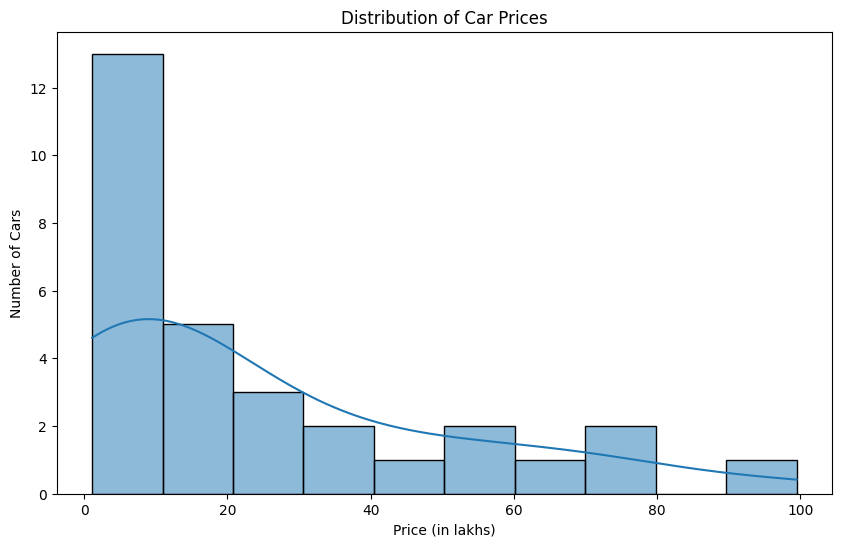

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Car_price'], bins=10, kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price (in lakhs)')
plt.ylabel('Number of Cars')
plt.show()


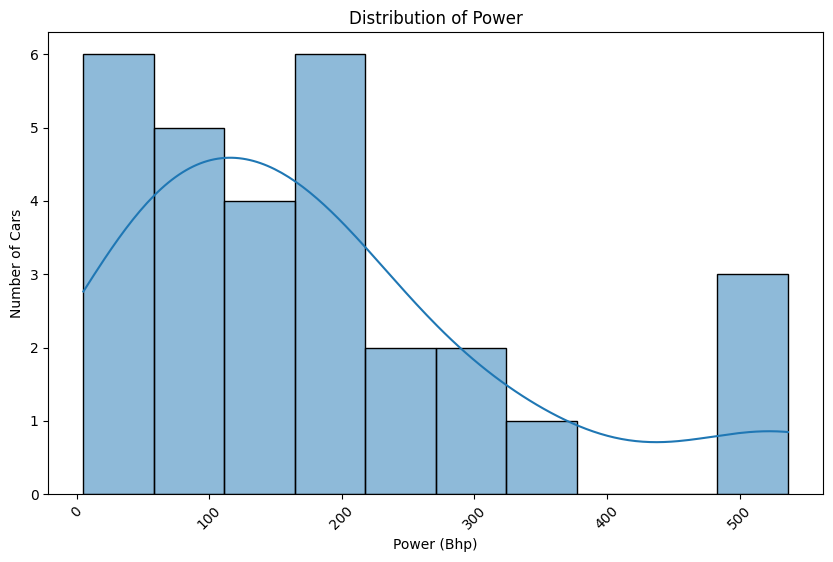

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Power'], bins=10, kde=True)
plt.xticks(rotation=45) 
plt.title('Distribution of Power')
plt.xlabel('Power (Bhp)')
plt.ylabel('Number of Cars')
plt.show()


In [23]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Car_name      30 non-null     object 
 1   Car_price     30 non-null     float64
 2   Batter_cap    27 non-null     object 
 3   Drive_range   30 non-null     float64
 4   Power         29 non-null     float64
 5   Charge_time   30 non-null     float64
 6   transmission  28 non-null     object 
 7   Boot_space    30 non-null     float64
 8   Top_speed     30 non-null     float64
dtypes: float64(6), object(3)
memory usage: 2.2+ KB


None

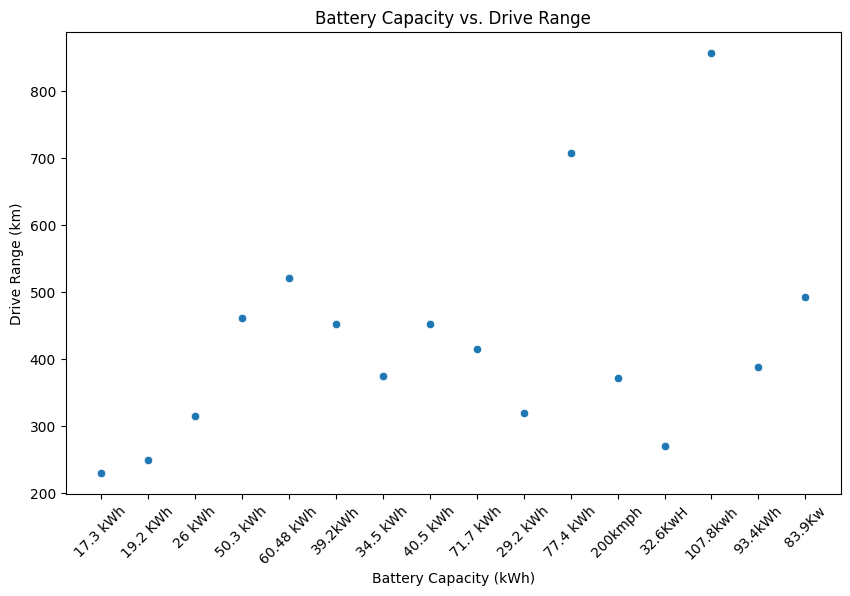

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Batter_cap', y='Drive_range', data=df)
plt.xticks(rotation=45)  # Adjust angle as needed

plt.title('Battery Capacity vs. Drive Range')
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('Drive Range (km)')
plt.show()


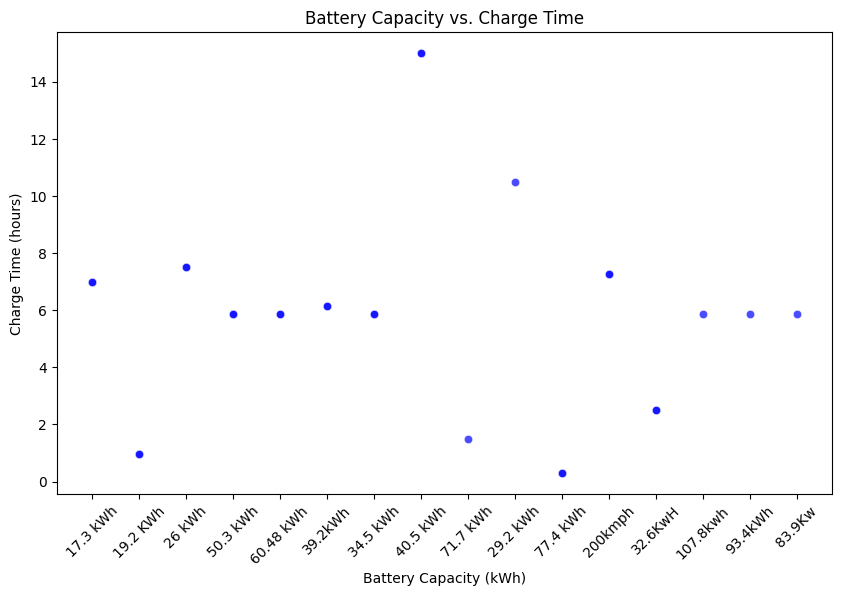

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Batter_cap', y='Charge_time', data=df, color='blue', alpha=0.7)
plt.xticks(rotation=45)  # Adjust angle as needed

plt.title('Battery Capacity vs. Charge Time')
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('Charge Time (hours)')


plt.show()


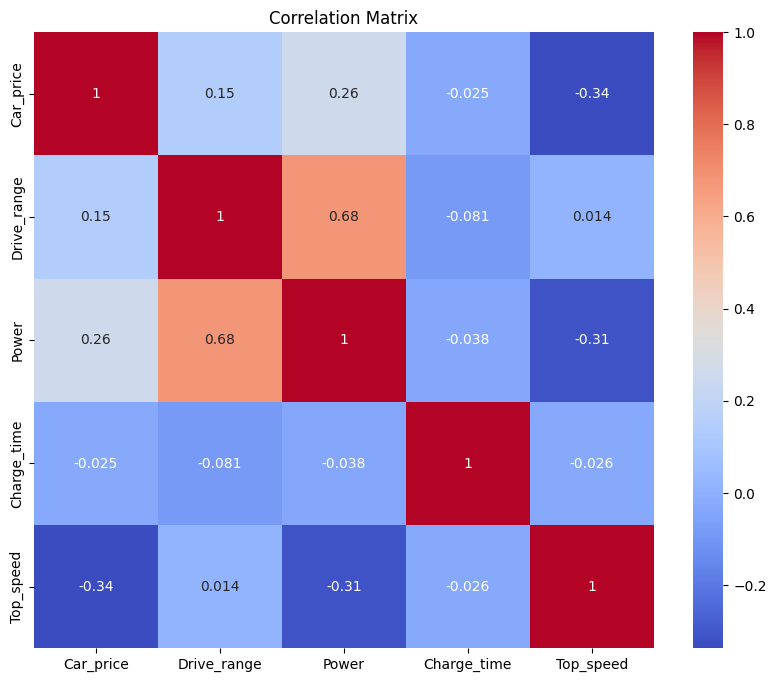

In [26]:
# Compute correlation matrix
corr = df[['Car_price', 'Drive_range', 'Power', 'Charge_time', 'Top_speed']].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


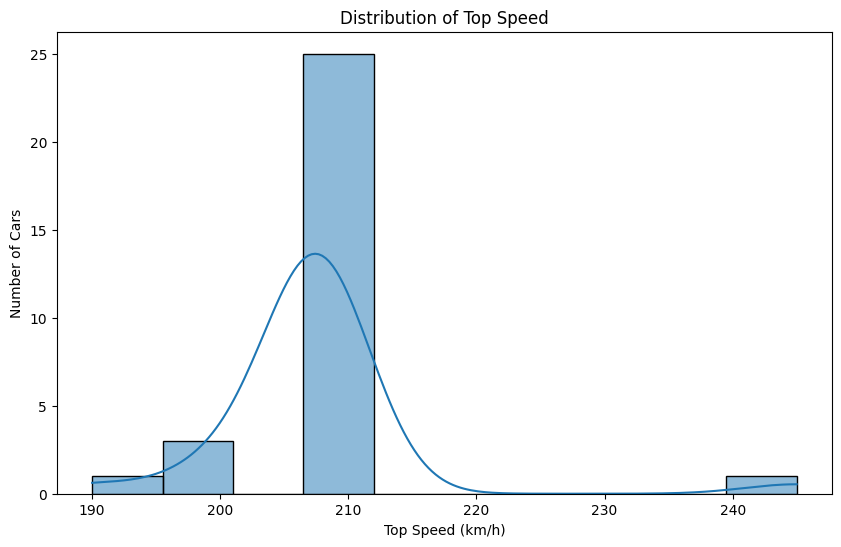

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Top_speed'], bins=10, kde=True)
plt.title('Distribution of Top Speed')
plt.xlabel('Top Speed (km/h)')
plt.ylabel('Number of Cars')
plt.show()


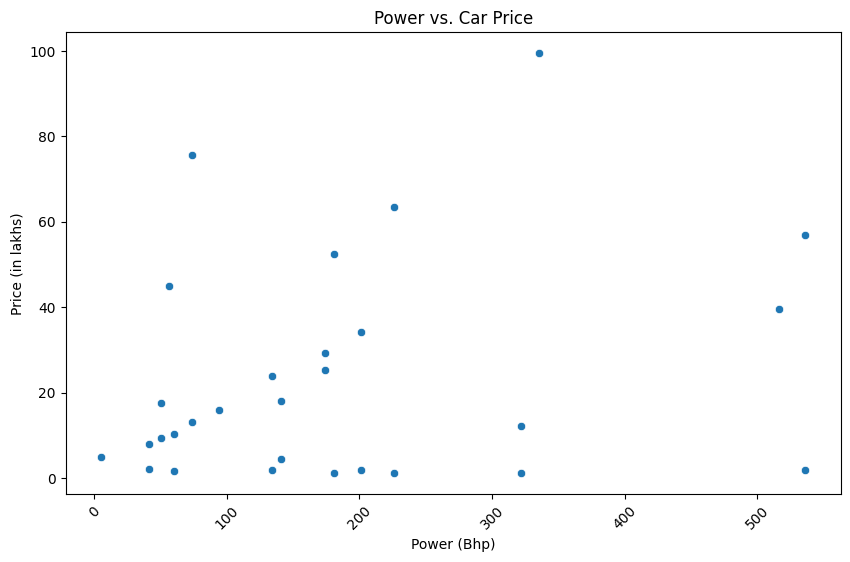

In [28]:
plt.figure(figsize=(10, 6))
df_sorted2 = df.sort_values(by='Car_price', ascending=True)
bx=sns.scatterplot(x='Power', y='Car_price', data=df_sorted2)
plt.xticks(rotation=45) 
plt.title('Power vs. Car Price')
plt.xlabel('Power (Bhp)')
plt.ylabel('Price (in lakhs)')

plt.show()


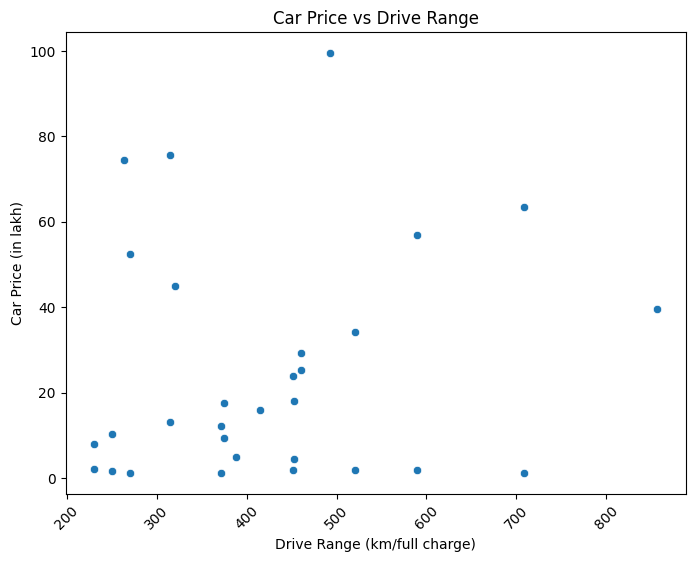

In [32]:
# Scatter plot between Car Price and Drive Range
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Drive_range', y='Car_price', data=df)
plt.xticks(rotation=45) 
plt.title('Car Price vs Drive Range')
plt.xlabel('Drive Range (km/full charge)')
plt.ylabel('Car Price (in lakh)')

plt.show()


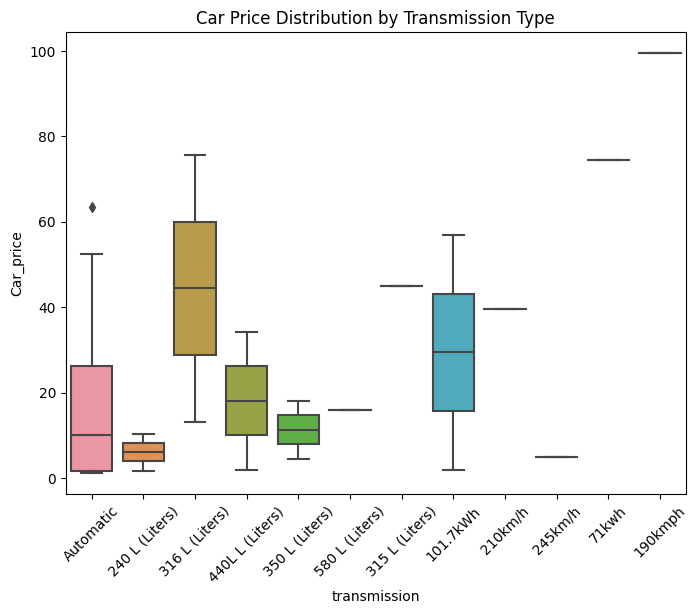

In [31]:
# Boxplot for Car Price by Transmission
plt.figure(figsize=(8, 6))
plt.xticks(rotation=45)  # Adjust angle as needed

sns.boxplot(x='transmission', y='Car_price', data=df)
plt.title('Car Price Distribution by Transmission Type')
plt.show()


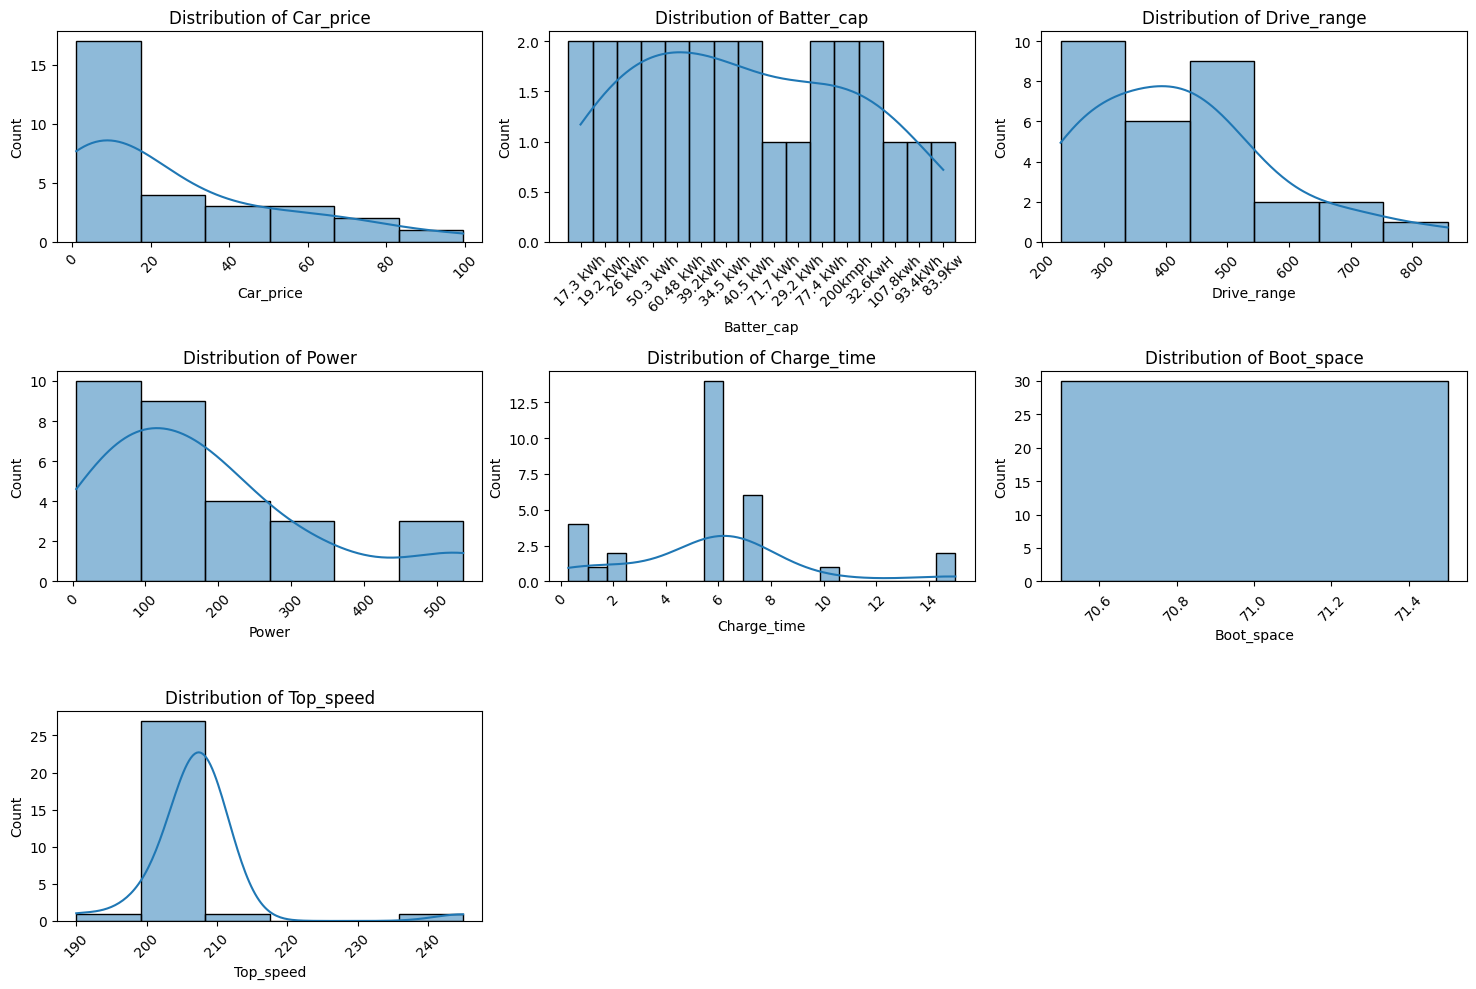

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting histograms for numerical columns
numeric_columns = ['Car_price', 'Batter_cap', 'Drive_range', 'Power', 'Charge_time', 'Boot_space', 'Top_speed']

plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[column], kde=True)
    plt.xticks(rotation=45)  # Adjust angle as needed

    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()


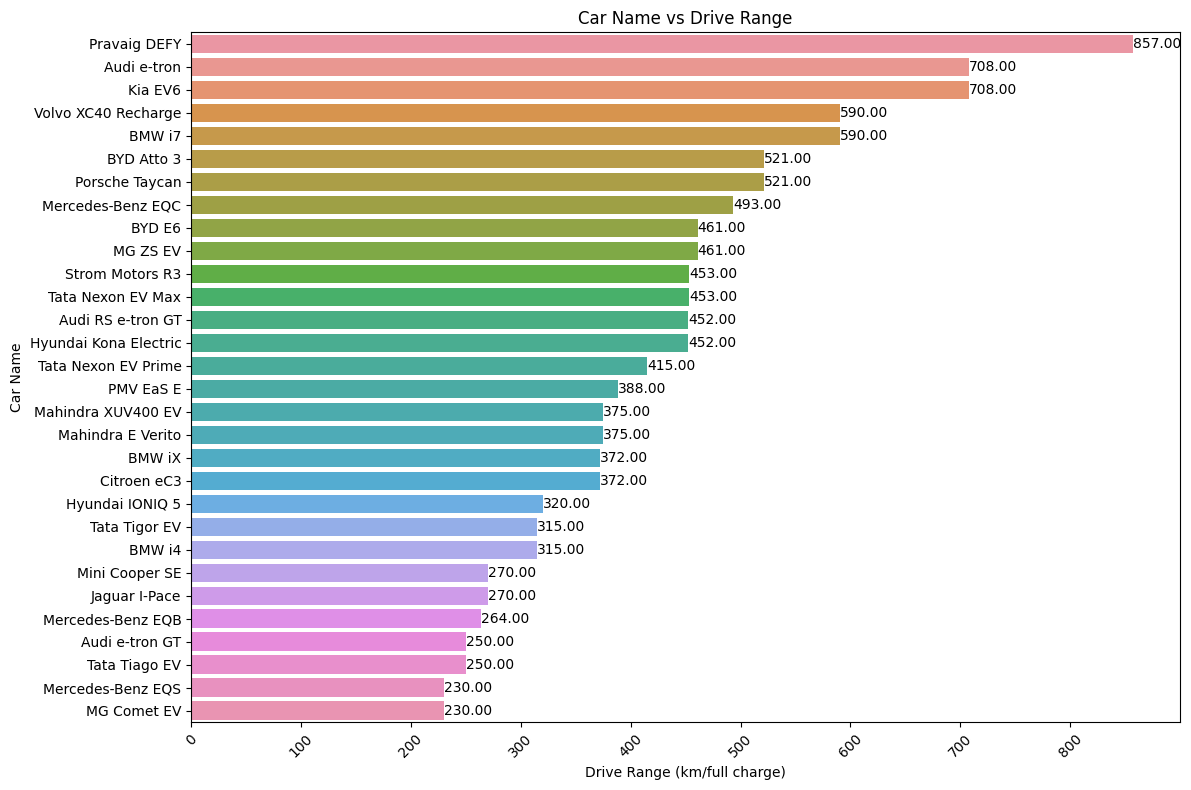

In [34]:


# Sorting the data by Drive_range for better visualization
df_sorted = df.sort_values(by='Drive_range', ascending=False)

# Bar plot for Car Name vs Drive Range
plt.figure(figsize=(12, 8))
bx=sns.barplot(x='Drive_range', y='Car_name', data=df_sorted)
plt.title('Car Name vs Drive Range')
plt.xlabel('Drive Range (km/full charge)')
plt.ylabel('Car Name')
plt.xticks(rotation=45)
plt.tight_layout()
for index, value in enumerate(df_sorted['Drive_range']):
    bx.text(value, index, f'{value:.2f}', color='black', va="center") 
plt.show()


posx and posy should be finite values
posx and posy should be finite values


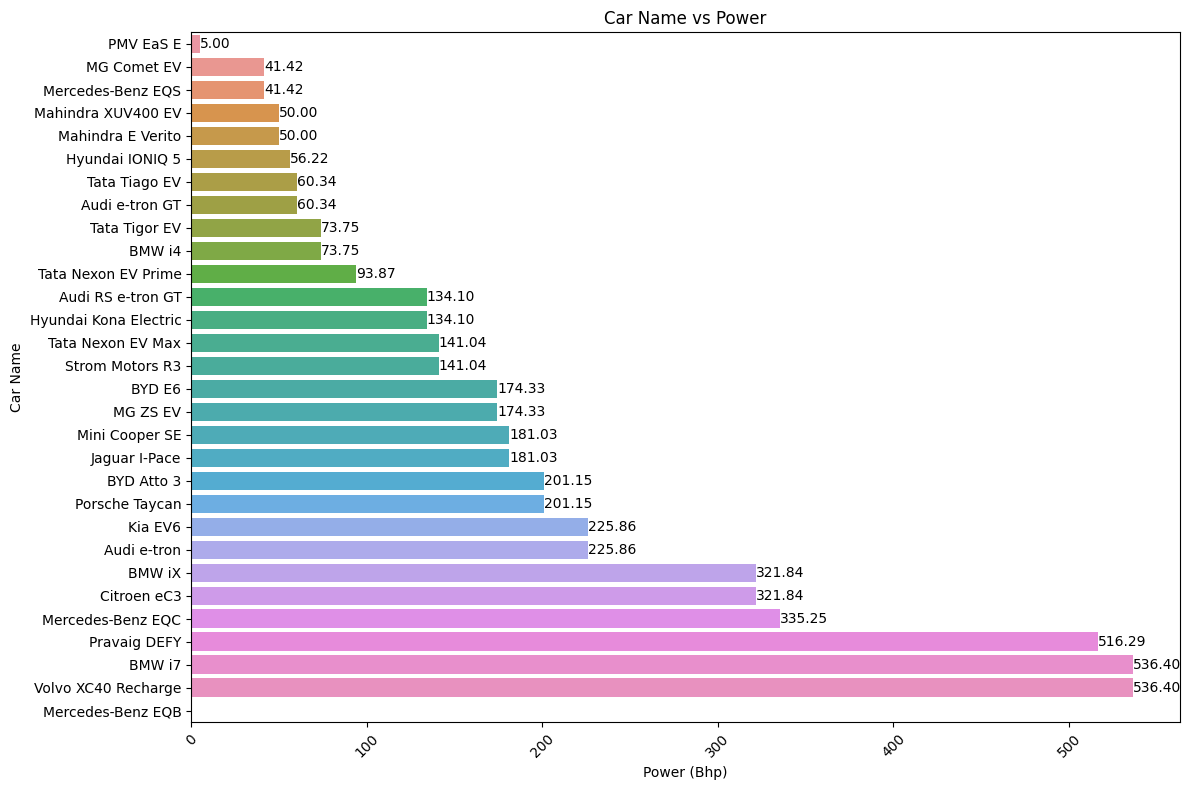

In [35]:
# Bar plot for Car Name vs Power
plt.figure(figsize=(12, 8))
df_sorted = df.sort_values(by='Power', ascending=True)
ax=sns.barplot(x='Power', y='Car_name', data=df_sorted)
plt.title('Car Name vs Power')
plt.xlabel('Power (Bhp)')
plt.ylabel('Car Name')
plt.xticks(rotation=45)
plt.tight_layout()
for index, value in enumerate(df_sorted['Power']):
    ax.text(value, index, f'{value:.2f}', color='black', va="center") 
plt.show()


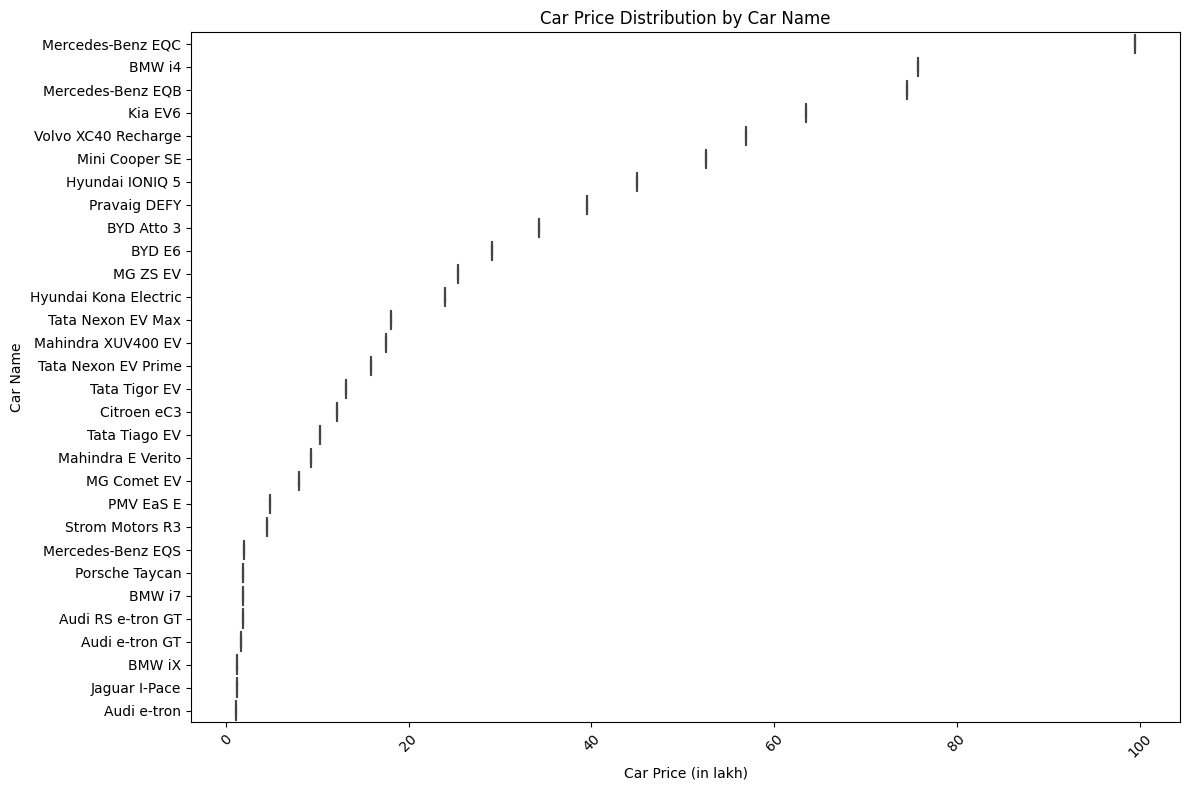

In [36]:
# Sorting the data by Car Price for better visualization
df_sorted = df.sort_values(by='Car_price', ascending=False)

# Boxplot for Car Price by Car Name
plt.figure(figsize=(12, 8))
sns.boxplot(x='Car_price', y='Car_name', data=df_sorted)
plt.title('Car Price Distribution by Car Name')
plt.xlabel('Car Price (in lakh)')
plt.ylabel('Car Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


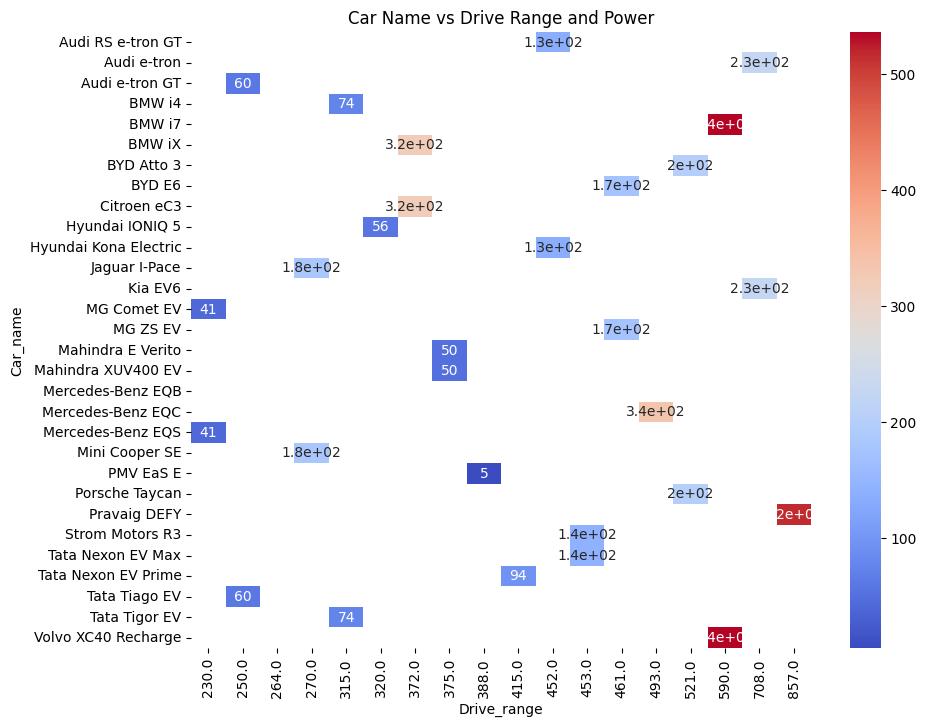

In [50]:
# Pivoting the data for heatmap visualization
heatmap_data = df.pivot(index="Car_name", columns="Drive_range", values="Power")

# Creating a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('Car Name vs Drive Range and Power')
plt.show()


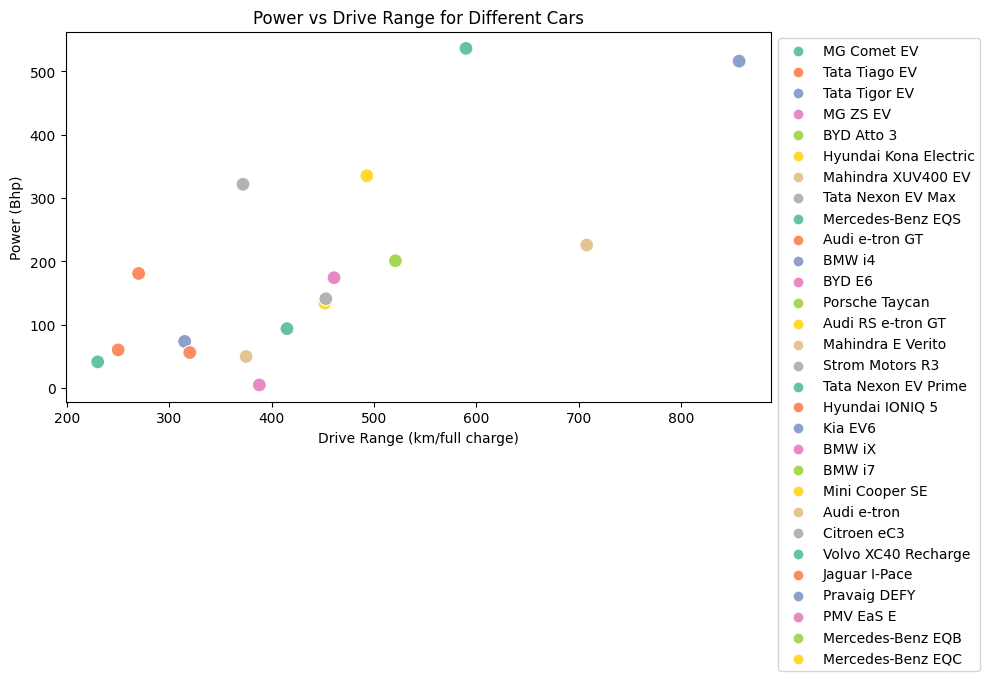

In [37]:
# Scatter plot for Power vs Drive Range
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Drive_range', y='Power', hue='Car_name', data=df, palette='Set2', s=100)
plt.title('Power vs Drive Range for Different Cars')
plt.xlabel('Drive Range (km/full charge)')
plt.ylabel('Power (Bhp)')
plt.legend(loc='best', bbox_to_anchor=(1, 1))  # To avoid overlap
plt.tight_layout()
plt.show()
